# Análisis de sentimiento

### Introducción

En NLP, el análisis de sentimiento es el proceso mediante el cual, se busca detectar la subjetividad, polaridad e intensidad en un fragmento de texto.

 - Subjetividad: sentimientos expresados
 - Polaridad: deterctar si es un sentimiento positivo o negativo
 - Intensidad: fuerza del sentimiento u opinión
 
### Configuración de nuestro dataset

Los datos están extraidos de [Reviews de Amazon](http://jmcauley.ucsd.edu/data/amazon/)

#### Dataset para clasificación binaria 

Se crea un dataset formado por:

- 3000 registros para 4 y 5 estrellas.
- 3000 registros para 1 y 2 estrellas.

Esto lo haremos para los 4 datas, con lo que acabaremos trabajando con 24.000 registros.

#### Dataset para clasificación múltiple

Se crea un nuevo dataset y se incluyen los registros con 3 estrellas. También habrá que crear unas nuevas etiquetas para éstas.

Recordemos que para la clasificación multiclase, el dataset estará formado por:
- 2000 registros para 4 y 5 estrellas.
- 2000 registros para 1 y 2 estrellas.
- 2000 registros para 3 estrellas.

No olvidemos que esto es para cada uno de ellos, con lo que acabaremos trabajando con un dataset de 24.000, igual que para la clasificación binaria.


 
### Que caminos tomaremos para realizar el análisis de sentimientos.

Para realizar el análisis de sentimiento, abordaremos cuatro caminos diferentes, para poder obtener diferentes resultados y ver cual funciona mejor.

1. Clasificación binaria sin preprocesado
2. Clasificación binaria con preprocesado.
3. Clasificación multiclase: sin preprocesado
4. Clasificación multiclase con preprocesado.


### Estructura de este notebook

0. Cargamos las librerías.
1. Cargamos los datos, creamos los datasets y las etiquetas.
2. Función train test split
3. Clasificación binaria.
    3.1 Sin preprocesado.
    3.2 Con preprocesado.
4. Clasificación multiclase.
    4.1 Sin preprocesado.
    4.2 Con preprocesado.
5. Conclusiones

## 0. Cargamos las librerías necesarias

In [228]:
import sys
sys.path.append('../..')


import random
import numpy as np
import pandas as pd

import json
import re

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns

import nltk 

from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer

import gensim
from gensim.corpora import Dictionary


## 1. Cargamos los datos

In [171]:
#cargamos el dataset de Videogames
dfVideogames = pd.read_json('data/Videogames.json', lines = True)
#cargamos el dataset de Babies
dfBaby = pd.read_json('data/Baby.json', lines = True)
#cargamos el dataset de Health and Personal Care
dfHealth = pd.read_json('data/Health.json', lines = True) 
#cargamos el dataset de Pets Supplies
dfPets = pd.read_json('data/Pets.json', lines = True)

Comprobamos que se hayan cargado bien los datos.

In [172]:
print('Dataset de videojuegos')
print(dfVideogames.shape)


print('Dataset de bebes:')
print(dfBaby.shape)


print('Dataset de suministros de mascotas:')
print(dfPets.shape)


print('Dataset de salud y cuidado personal:')
print(dfHealth.shape)
dfHealth.head()

Dataset de videojuegos
(231780, 9)
Dataset de bebes:
(160792, 9)
Dataset de suministros de mascotas:
(157836, 9)
Dataset de salud y cuidado personal:
(346355, 9)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ALC5GH8CAMAI7,159985130X,AnnN,"[1, 1]",This is a great little gadget to have around. ...,5,Handy little gadget,1294185600,"01 5, 2011"
1,AHKSURW85PJUE,159985130X,"AZ buyer ""AZ buyer""","[1, 1]",I would recommend this for a travel magnifier ...,4,Small & may need to encourage battery,1329523200,"02 18, 2012"
2,A38RMU1Y5TDP9,159985130X,"Bob Tobias ""Robert Tobias""","[75, 77]",What I liked was the quality of the lens and t...,4,Very good but not great,1275955200,"06 8, 2010"
3,A1XZUG7DFXXOS4,159985130X,Cat lover,"[56, 60]",Love the Great point light pocket magnifier! ...,4,great addition to your purse,1202428800,"02 8, 2008"
4,A1MS3M7M7AM13X,159985130X,Cricketoes,"[1, 1]",This is very nice. You pull out on the magnifi...,5,Very nice and convenient.,1313452800,"08 16, 2011"


Vamos a quedarnos únicamente con las variables 'reviewText' y 'overall', y eliminaremos los valores NA's

In [173]:
dfVideogames = dfVideogames[['reviewText', 'overall']]
dfVideogames.dropna(inplace = True)
print(dfVideogames.shape)
dfBaby = dfBaby[['reviewText', 'overall']]
dfBaby.dropna(inplace = True)
print(dfBaby.shape)
dfPets = dfPets[['reviewText', 'overall']]
dfPets.dropna(inplace = True)
print(dfPets.shape)
dfHealth = dfHealth[['reviewText', 'overall']]
dfHealth.dropna(inplace = True)
print(dfHealth.shape)

(231780, 2)
(160792, 2)
(157836, 2)
(346355, 2)


### 1.0. Creamos nuestro dataset para la clasificación binaria

Vamos a confeccionar el dataset con el que vamos a evaluar nuestro modelo para la parte de clasificación binaria (2.500 positivas + 2.500 negativas) * dataset.

In [174]:
dfVideogamesPositive= dfVideogames[dfVideogames['overall'] >= 4]
dfVideogamesNegative= dfVideogames[dfVideogames['overall'] <= 2]

dfBabyPositive = dfBaby[dfBaby['overall'] >= 4] 
dfBabyNegative = dfBaby[dfBaby['overall'] <= 2]

dfPetsPositive = dfPets[dfPets['overall'] >= 4] 
dfPetsNegative = dfPets[dfPets['overall'] <= 2]

dfHealthPositive = dfHealth[dfHealth['overall'] >= 4]
dfHealthNegative = dfHealth[dfHealth['overall'] <= 2]

Concatenamos los 4 dataset para cogiendo sólo los primeros 2500 registros de positivos y negativos para confeccionar 'df'

In [175]:
df = pd.concat([dfVideogamesPositive[:3000], dfVideogamesNegative[:3000], 
                dfBabyPositive[:3000], dfBabyNegative[:3000], 
                dfHealthPositive[:3000], dfHealthNegative[:3000],
                dfPetsPositive[:3000], dfPetsNegative[:3000]], axis = 0, ignore_index = True)

print(df.shape)
df.head()

(24000, 2)


,reviewText,overall
0,If you like rally cars get this game you will ...,4
1,I had Dirt 2 on Xbox 360 and it was an okay ga...,4
2,"Overall this is a well done racing game, with ...",4
3,Loved playing Dirt 2 and I thought the graphic...,5
4,I initially gave this one star because it was ...,4


Ordenamos nuestro data por la variable 'overall', así integramos todos los subsets.

In [176]:
df.sort_values('overall', axis = 0, ascending = True, inplace = True)
df.reset_index(drop=True,inplace=True)
df

,reviewText,overall
0,For $12.92 I did not expect much and that is e...,1
1,This salt was way too intense for me. I had b...,1
2,I don't know if it's the &#34;Oaken&#34; or so...,1
3,This is a review for the 4 ounce Avon SKIN-SO-...,1
4,This is the worst game of its type. Save your...,1
...,...,...
23995,Simple....effective...nothing fancy...works fi...,5
23996,"So cute, organizes the closet so I can easily ...",5
23997,It is it is. Nothing special about the divider...,5
23998,These look great in the closet and do what the...,5


### 1.1. Creación de las etiquetas para Clasificación Binaria

Ahora crearemos nuestras etiquetas, (positive, negative) para poder evaluar nuestro modelo. Asignaremos el valor 0 a las negativas y 1 a las positivas.

In [177]:
def label_sentiment(row):
    if int(row['overall']) <= 2:
        return 0
    else:
        return 1

In [178]:
df['sentiment_label'] = df.apply(lambda row: label_sentiment(row), axis=1)

In [179]:
df

,reviewText,overall,sentiment_label
0,For $12.92 I did not expect much and that is e...,1,0
1,This salt was way too intense for me. I had b...,1,0
2,I don't know if it's the &#34;Oaken&#34; or so...,1,0
3,This is a review for the 4 ounce Avon SKIN-SO-...,1,0
4,This is the worst game of its type. Save your...,1,0
...,...,...,...
23995,Simple....effective...nothing fancy...works fi...,5,1
23996,"So cute, organizes the closet so I can easily ...",5,1
23997,It is it is. Nothing special about the divider...,5,1
23998,These look great in the closet and do what the...,5,1


Como ya no necesitamos la variable 'overall' la eliminamos del dataset

In [180]:
del(df['overall'])
df

,reviewText,sentiment_label
0,For $12.92 I did not expect much and that is e...,0
1,This salt was way too intense for me. I had b...,0
2,I don't know if it's the &#34;Oaken&#34; or so...,0
3,This is a review for the 4 ounce Avon SKIN-SO-...,0
4,This is the worst game of its type. Save your...,0
...,...,...
23995,Simple....effective...nothing fancy...works fi...,1
23996,"So cute, organizes the closet so I can easily ...",1
23997,It is it is. Nothing special about the divider...,1
23998,These look great in the closet and do what the...,1


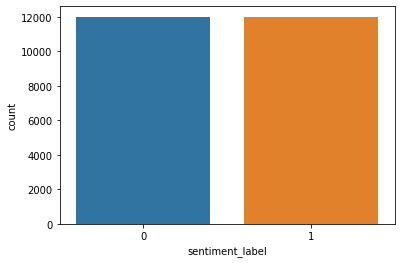

In [181]:
sns.countplot(x='sentiment_label', data = df)

### 2.0. Creamos nuestro dataset para la clasificación múltiple

Usaremos los subset creados para la calsificación binaria y le añadiremos los subsets para los registros de 3 estrellas.

In [182]:
dfVideogamesNeutral = dfVideogames[dfVideogames['overall'] == 3]
dfBabyNeutral = dfBaby[dfBaby['overall'] == 3]
dfPetsNeutral = dfPets[dfPets['overall'] == 3]
dfHealthNeutral = dfHealth[dfHealth['overall'] == 3]

In [183]:
dfMultiClass = pd.concat([dfVideogamesPositive[:2000], dfVideogamesNegative[:2000], dfVideogamesNeutral[:2000],
                        dfBabyPositive[:2000], dfBabyNegative[:2000], dfBabyNeutral[:2000], 
                        dfHealthPositive[:2000], dfHealthNegative[:2000], dfHealthNeutral[:2000],
                        dfPetsPositive[:2000], dfPetsNegative[:2000], dfPetsNeutral[:2000]], axis = 0, ignore_index = True)

In [184]:
print(dfMultiClass.shape)
dfMultiClass.head()

(24000, 2)


,reviewText,overall
0,If you like rally cars get this game you will ...,4
1,I had Dirt 2 on Xbox 360 and it was an okay ga...,4
2,"Overall this is a well done racing game, with ...",4
3,Loved playing Dirt 2 and I thought the graphic...,5
4,I initially gave this one star because it was ...,4


Mezclaremos el dataset para que los grupos queden integrados, ordenandolos por las estrellas.

In [185]:
dfMultiClass.sort_values('overall', axis = 0, ascending = True, inplace = True)
dfMultiClass.reset_index(drop=True,inplace=True)
dfMultiClass

,reviewText,overall
0,I recently saw this at a local AC Moore store....,1
1,"I bought two, one for upstairs and one for dow...",1
2,"Love the idea of the scoop and hide, but this ...",1
3,After spending 15 minutes using Goo Gone Stick...,1
4,I bought one of theseBooda Scoop'N Hide Litter...,1
...,...,...
23995,We live in Maryland which turns out to be tick...,5
23996,All of the other brands are a waste of time. ...,5
23997,It works great. The price was the best I found...,5
23998,"Shipping was fast, got it within a week with F...",5


### 2.1. Creación de las etiquetas para Clasificación Multiple

Ahora crearemos nuestras etiquetas, (positive, neutral y negative) para poder evaluar nuestro modelo. Para mantener una coherencia dentro del ejercicio, asignaremos el valor 0 para las negativas, 1 para las positivas y 2 para las neutrales.

In [186]:
def label_sentimentMultiClass(row):
    if int(row['overall']) <= 2:
        return 0
    elif int(row['overall']) >= 4:
        return 1
    else:
        return 2

In [187]:
dfMultiClass['sentiment_label'] = dfMultiClass.apply(lambda row: label_sentimentMultiClass(row), axis=1)

Eliminamos la variable 'overall'

In [188]:
del(dfMultiClass['overall'])
dfMultiClass

,reviewText,sentiment_label
0,I recently saw this at a local AC Moore store....,0
1,"I bought two, one for upstairs and one for dow...",0
2,"Love the idea of the scoop and hide, but this ...",0
3,After spending 15 minutes using Goo Gone Stick...,0
4,I bought one of theseBooda Scoop'N Hide Litter...,0
...,...,...
23995,We live in Maryland which turns out to be tick...,1
23996,All of the other brands are a waste of time. ...,1
23997,It works great. The price was the best I found...,1
23998,"Shipping was fast, got it within a week with F...",1


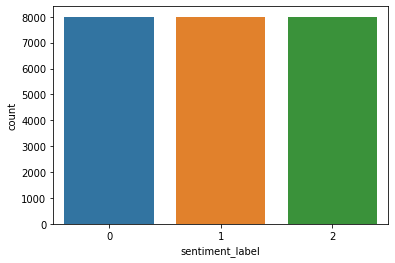

In [93]:
sns.countplot(x='sentiment_label', data = dfMultiClass)

## 2. Train, test split function

Creamos una funcion para dividir en train y test, procurando que esten bien balanceadas (mismo número de negativas y positivas para clasificacion binaria y mismo número de negativas, positivas y neutrales para clasificación múltiple)

In [189]:
def trainTestSplit (data, processed = False):
    if processed == True:
        return(train_test_split(
        data['reviewProcessed'],
        data['sentiment_label'],
        train_size=0.75,
        test_size=0.25,
        random_state=42,
        shuffle=True
        ))
    else:
        return(train_test_split(
        data['reviewText'],
        data['sentiment_label'],
        train_size=0.75,
        test_size=0.25,
        random_state=42,
        shuffle=True
        ))

## 3. Clasificación Binaria.

### 3.1 Clasificación Binaria Sin preprocesado.


Ahora que ya tenemos preparado nuestro dataset, podemos centrarnos en como abordar la resolución para la clasificación binaria.

Para ello usaremos el método TF-IDF Vectorizer. 
Este clasificador, no puede procesar directamente los reviews de texto en su forma original, si no vectores de características numéricas.
Para ello usaremos el modelo de la bolsa de palabras, donde para cada review, se tiene en cuenta la presencia y frecuencia de palabras, pero se ignora el contexto.

Vamos a ello!

#### 3.1.0 Dividimos en train y test

In [190]:
X_train, X_test, y_train, y_test = trainTestSplit(df)

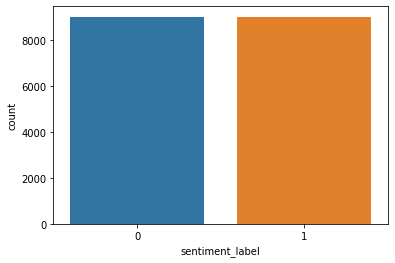

In [191]:
sns.countplot(x= y_train)

Como se puede comprobar, nuestro conjunto de train esta bien balanceado, por consiguiente, test también lo estará.

#### 3.1.1 TfidfVectorizar

In [192]:
cv_sinProcesado = TfidfVectorizer()
cv_sinProcesado.fit(X_train)


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
Una muestra de nuestra BoW

In [193]:
print(list(cv_sinProcesado.vocabulary_.items())[:20])

[('got', 15735), ('to', 35715), ('see', 30776), ('peter', 25830), ('molyneux', 22597), ('demonstrate', 9961), ('and', 2616), ('explain', 13084), ('black', 4740), ('white', 38695), ('in', 18041), ('person', 25762), ('at', 3377), ('mit', 22437), ('february', 13560), ('of', 24179), ('2000', 417), ('was', 38285), ('intrigued', 18806), ('by', 5889)]


In [194]:
print(len(cv_sinProcesado.vocabulary_))

39626


In [195]:
X_train_tfidf_sinProcesado =cv_sinProcesado.transform(X_train)
X_test_tfidf_sinProcesado = cv_sinProcesado.transform(X_test)

#### 3.1.2 Regresión Logística

Calculamos que parametro nos da una mayor accuracy

In [196]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=1500)
    lr.fit(X_train_tfidf_sinProcesado, y_train)
    
    train_predict = lr.predict(X_train_tfidf_sinProcesado)
    test_predict = lr.predict(X_test_tfidf_sinProcesado)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.8046666666666666
Accuracy for C=0.05: 0.8238333333333333
Accuracy for C=0.25: 0.8511666666666666
Accuracy for C=0.5: 0.8586666666666667
Accuracy for C=1: 0.8638333333333333
Accuracy for C=10: 0.8696666666666667
Accuracy for C=100: 0.8555
Accuracy for C=1000: 0.849
Accuracy for C=10000: 0.8438333333333333


Entrenamos el modelo para c= 10

In [197]:
lr_tfidf_sinProcesado = LogisticRegression(C=10, solver='lbfgs', max_iter=1500)

lr_tfidf_sinProcesado.fit(X_train_tfidf_sinProcesado, y_train)  # train

y_pred_tfidf_sinProcesado = lr_tfidf_sinProcesado.predict(X_test_tfidf_sinProcesado)  # test


#### 3.1.3 Resultado

In [199]:
print('TfIdfVectorizer sin preprocesado\n')
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, y_pred_tfidf_sinProcesado)))
print('\nClassification report:\n{}'.format(classification_report(y_test, y_pred_tfidf_sinProcesado)))
print('Accuracy score:{}'.format(accuracy_score(y_test, y_pred_tfidf_sinProcesado)))


TfIdfVectorizer sin preprocesado

Confussion matrix:
[[2617  373]
 [ 409 2601]]

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      2990
           1       0.87      0.86      0.87      3010

    accuracy                           0.87      6000
   macro avg       0.87      0.87      0.87      6000
weighted avg       0.87      0.87      0.87      6000

Accuracy score:0.8696666666666667


Comete algunos errores, pero en general predice bastante bien los reviews.
Si nos fijamos en el recall, y recordemos que el 0 es para las negativas y el 1 para las positivas, predice mejor los reviews negativos que los positivos.

### 3.2 Con preprocesado.

#### 3.2.1 Procesado

Realizaremos los siguientes:

- Tokenización: dividir el texto en oraciones y las oraciones en palabras.
- Poner en minúsculas las palabras y eliminar la puntuación.
- Se eliminan las palabras que tienen menos de 2 caracteres.
- Todas las palabras vacías se eliminan.
- Lematización: las palabras en 3ª persona se cambian a 1ª, y los verbos en tiempo pasado y futuro se cambian a presente.
- Eliminaremos las url.

Para ello, utilizamos gensim para eliminar los stopwords, y las palabras con un len inferior a 3. Así que en esta primera iteración empezaremos con esta opción.

Usaremos lemmatizer para pasar eliminar las mayúsculas, los plurales y los signos de puntuación. Y stemmer para poner los verbos en presente y pasar de 3ª persona a 1ª.

Para eliminar las url, usaremos la expresión regular (re).

In [200]:
wordnet_lemmatizer = WordNetLemmatizer()

def deleteUrl(text):
    text = re.sub(r"http\S+", "", text)
    return text

def preprocess(text):
    result = []
    text = deleteUrl(text)
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(wordnet_lemmatizer.lemmatize(token, pos="v"))
    return result

In [201]:
print('Original text:\n{}\n\n'.format(df['reviewText'][0]))
print('Processed text:\n{}'.format(preprocess(df['reviewText'][0])))

Original text:
For $12.92 I did not expect much and that is exactly what I got - not much. I had been using a small bowl of water with a few drops of liquid soap that I placed under a night light and changed every few days. Nothing wrong with this method except that I thought it would be nice if I only had to do something every 3 - 4 weeks as claimed by Victor. As expected, the flea trap is made of about one or two cents worth of very thin plastic. There are two parts to the trap. The bottom part is for installing the sticky pad. Good luck with that. The top part holds the night light. Placing the top onto the bottom leaves it somewhat cock-eyed due to lame construction. I placed the trap on the floor away from my dog's reach and plugged in the power cord. The small bulb gives out a surprisingly bright light for its size. The word in the local flea community is "stay away from this bright light because you may accidently step on a sticky pad". The fleas in this area all heeded that adv

Como podemos observar, el preprocesado funcionas bastante bien, así que vamos a aplicarlo a nuestro dataset.

In [202]:
processed_texts = []
separator = ', '
for text in df['reviewText']:
    processed_texts.append(separator.join(preprocess(text)))

Añadimos las reviews procesadas a nuestro dataframe

In [203]:
df['reviewProcessed'] = processed_texts
df

,reviewText,sentiment_label,reviewProcessed
0,For $12.92 I did not expect much and that is e...,0,"expect, exactly, small, bowl, water, drop, liq..."
1,This salt was way too intense for me. I had b...,0,"salt, intense, brand, packets, work, great, ha..."
2,I don't know if it's the &#34;Oaken&#34; or so...,0,"know, oaken, botanicals, combination, stuff, a..."
3,This is a review for the 4 ounce Avon SKIN-SO-...,0,"review, ounce, avon, skin, soft, guard, plus, ..."
4,This is the worst game of its type. Save your...,0,"worst, game, type, save, money, graphics, year..."
...,...,...,...
23995,Simple....effective...nothing fancy...works fi...,1,"simple, effective, fancy, work, fine"
23996,"So cute, organizes the closet so I can easily ...",1,"cute, organize, closet, easily, certain, size,..."
23997,It is it is. Nothing special about the divider...,1,"special, dividers, stickers, reuse, size, larger"
23998,These look great in the closet and do what the...,1,"look, great, closet, organize, clothe, size, e..."


Eliminamos la columna reviewText

In [204]:
del(df['reviewText'])
df

,sentiment_label,reviewProcessed
0,0,"expect, exactly, small, bowl, water, drop, liq..."
1,0,"salt, intense, brand, packets, work, great, ha..."
2,0,"know, oaken, botanicals, combination, stuff, a..."
3,0,"review, ounce, avon, skin, soft, guard, plus, ..."
4,0,"worst, game, type, save, money, graphics, year..."
...,...,...
23995,1,"simple, effective, fancy, work, fine"
23996,1,"cute, organize, closet, easily, certain, size,..."
23997,1,"special, dividers, stickers, reuse, size, larger"
23998,1,"look, great, closet, organize, clothe, size, e..."


#### 3.2.2 Separamos en train y test

In [205]:
X_trainProcessed, X_testProcessed, y_trainProcessed, y_testProcessed = trainTestSplit(df, True)

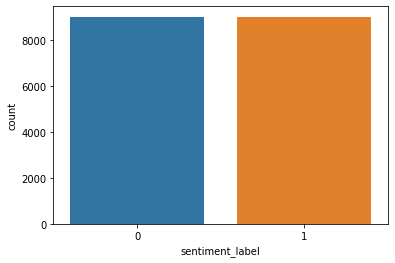

In [206]:
sns.countplot(x= y_trainProcessed)

Como se puede comprobar, nuestro conjunto de train esta bien balanceado, por consiguiente, test también lo estará.

#### 3.2.3 TfidfVectorizer

In [207]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=5000,
    ngram_range=(1, 3)
)
cv.fit(X_trainProcessed)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=5000,
                min_df=5, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [208]:
X_train_tfidf_Processed = cv.transform(X_trainProcessed)
X_test_tfidf_Processed = cv.transform(X_testProcessed)

#### 3.2.4 Regresión Logística

Calculamos que parametro nos da una mayor accuracy

In [241]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc_Processed = list()
test_acc_Processed = list()
for c in c_params:
    lrProcessed = LogisticRegression(C=c, solver='lbfgs', max_iter=2500)
    lrProcessed.fit(X_train_tfidf_Processed, y_trainProcessed)
    
    train_predict_Processed = lrProcessed.predict(X_train_tfidf_Processed)
    test_predict_Processed = lrProcessed.predict(X_test_tfidf_Processed)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_testProcessed, test_predict_Processed)))
    
    train_acc_Processed.append(accuracy_score(y_trainProcessed, train_predict_Processed))
    test_acc_Processed.append(accuracy_score(y_testProcessed, test_predict_Processed))

Accuracy for C=0.01: 0.8003333333333333
Accuracy for C=0.05: 0.8155
Accuracy for C=0.25: 0.8325
Accuracy for C=0.5: 0.8401666666666666
Accuracy for C=1: 0.843
Accuracy for C=10: 0.8395
Accuracy for C=100: 0.8195
Accuracy for C=1000: 0.7948333333333333
Accuracy for C=10000: 0.7773333333333333


Entrenamos para c=1


In [242]:
c = 1


lrProcessed = LogisticRegression(C=c, solver='lbfgs', max_iter=2500)
lrProcessed.fit(X_train_tfidf_Processed, y_trainProcessed)


test_predict_Processed = lrProcessed.predict(X_test_tfidf_Processed)

print ("Accuracy for C={}: {}".format(c, accuracy_score(y_testProcessed, test_predict_Processed)))



Accuracy for C=1: 0.843


#### 3.2.5 Resultado

In [243]:
print('TfIdfVectorizer con preprocesado\n')
print('Confussion matrix:\n{}'.format(confusion_matrix(y_testProcessed, test_predict_Processed)))
print('\nClassification report:\n{}'.format(classification_report(y_testProcessed, test_predict_Processed)))
print('Accuracy score:{}'.format(accuracy_score(y_testProcessed, test_predict_Processed)))

TfIdfVectorizer con preprocesado

Confussion matrix:
[[2510  480]
 [ 462 2548]]

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      2990
           1       0.84      0.85      0.84      3010

    accuracy                           0.84      6000
   macro avg       0.84      0.84      0.84      6000
weighted avg       0.84      0.84      0.84      6000

Accuracy score:0.843


Observemos que al aplicarle un procesado al texto, el modelo predice peor, y si nos fijamos, en esta ocasión, predice mejor los sentimiento positivos que los negativos.
Quizás deberíamos observar el top10 de la BoW de cada uno, y probablemente, en una predominarían las de lenguaje negativo y en la otra la del positivo

## 4. Clasificación multiclase.

Para esta parte del ejercicio, seguiremos la misma metodología empleada hasta ahora, pero en lugar de usa como modelo de parendizaje supervisado la Regresión Logística, en esta ocasión, usaremos Árboles de Decisiones, Bagging y Random Forest Classifier



Bagging construye múltiples árboles de decisión haciendo repetidamente remuestreo de los datos de entrenamiento con sustitución, y votando los árboles para hallar una predicción de consenso.
El clasificador Random Forest utiliza una serie de árboles de decisión, con el fin de mejorar la tasa de clasificación.

### 4.1 Sin preprocesado.

#### 4.1.1 Dividimos en train y test

In [247]:
XMultiClass_train, XMultiClass_test, yMultiClass_train, yMultiClass_test = trainTestSplit(dfMultiClass)

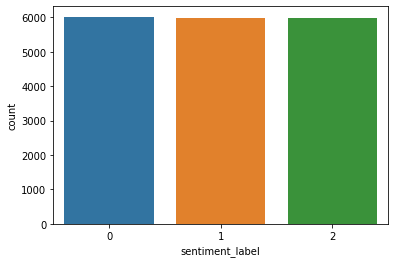

In [248]:
sns.countplot(x= yMultiClass_train)

Como se puede comprobar, nuestro conjunto de train esta bien balanceado, por consiguiente, test también lo estará.

#### 4.1.2 TfidfVectorizer Clasificación Multiple y Sin Preprocesado

In [249]:
cvMultiClass_sinProcesado = TfidfVectorizer()
cvMultiClass_sinProcesado.fit(XMultiClass_train)


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

Una muestra de nuestra BoW

In [250]:
print(list(cvMultiClass_sinProcesado.vocabulary_.items())[:20])

[('put', 27823), ('some', 32531), ('of', 24211), ('this', 35516), ('with', 39156), ('my', 23118), ('smoothies', 32265), ('and', 2682), ('sometimes', 32557), ('cereal', 6674), ('doesn', 11186), ('distort', 11042), ('the', 35274), ('flavor', 14154), ('which', 38883), ('is', 19050), ('great', 16101), ('for', 14454), ('me', 21754), ('avoiding', 3702)]


In [251]:
print(len(cvMultiClass_sinProcesado.vocabulary_))

39858


In [252]:
XMultiClass_train_tfidf_sinProcesado =cvMultiClass_sinProcesado.transform(XMultiClass_train)
XMultiClass_test_tfidf_sinProcesado = cvMultiClass_sinProcesado.transform(XMultiClass_test)

#### 4.1.3 Modelo para Clasificación Multiple y Sin Preprocesado

Instanciamos el modelo e indicamos el número de árboles que vamos a contruir
Primero probaremos que tal funciona con un modelo basado en arboles de decisiones y despues con bagging y random forest

#### Arbol de decisiones

Optimizamos los parámetros con gridsearch

best mean cross-validation score: 0.486
best parameters: {'max_depth': 12}


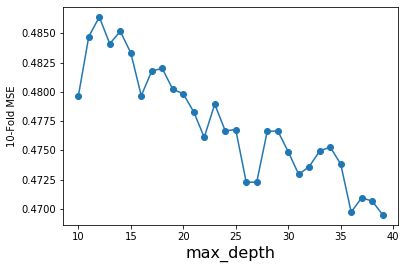

In [264]:
from sklearn.model_selection import GridSearchCV

maxDepthDT = range(10,40)
param_gridDT = {'max_depth': maxDepthDT }
gridDT= GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_gridDT, cv = 10)
gridDT.fit(XMultiClass_train_tfidf_sinProcesado, yMultiClass_train)
print("best mean cross-validation score: {:.3f}".format(gridDT.best_score_))
print("best parameters: {}".format(gridDT.best_params_))

scores = np.array(gridDT.cv_results_['mean_test_score'])
plt.plot(maxDepthDT,scores,'-o')
plt.xlabel('max_depth',fontsize=16)
plt.ylabel('10-Fold MSE')
plt.show()

In [268]:
maxDepthOptimoAD = gridDT.best_params_['max_depth']
treeModel = DecisionTreeClassifier(max_depth=maxDepthOptimoAD).fit(XMultiClass_train_tfidf_sinProcesado, yMultiClass_train)

print("Train: ",treeModel.score(XMultiClass_train_tfidf_sinProcesado, yMultiClass_train))
print("Test: ",treeModel.score(XMultiClass_test_tfidf_sinProcesado, yMultiClass_test))



Train:  0.6096666666666667
Test:  0.48966666666666664


Predecimmos para test

In [269]:
test_predictDT = treeModel.predict(XMultiClass_test_tfidf_sinProcesado)

#### Resultado

In [270]:
print('Arbol de decisiones sin preprocesado\n')
print('-' * 50)
print('Confussion matrix:\n{}'.format(confusion_matrix(yMultiClass_test, test_predictDT)))
print('\nClassification report:\n{}'.format(classification_report(yMultiClass_test, test_predictDT)))
print('Accuracy score:{}'.format(accuracy_score(yMultiClass_test, test_predictDT)))

Arbol de decisiones sin preprocesado

--------------------------------------------------
Confussion matrix:
[[ 747  477  756]
 [ 276 1111  624]
 [ 432  497 1080]]

Classification report:
              precision    recall  f1-score   support

           0       0.51      0.38      0.43      1980
           1       0.53      0.55      0.54      2011
           2       0.44      0.54      0.48      2009

    accuracy                           0.49      6000
   macro avg       0.50      0.49      0.49      6000
weighted avg       0.50      0.49      0.49      6000

Accuracy score:0.48966666666666664


#### Baggin y Random Forest

Optimizamos los parametros con gridSearch

best mean cross-validation score: 0.620
best parameters: {'max_depth': 29}


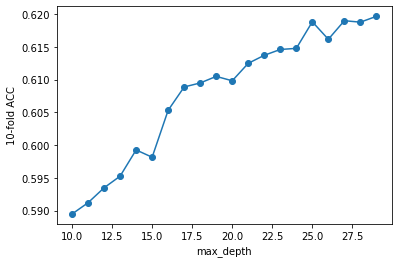

In [273]:
# grid search
maxDepthRF = range(10,30)
tuned_parametersRF = {'max_depth': maxDepthRF}

gridRF = GridSearchCV(RandomForestClassifier(random_state=0, n_estimators=200, max_features='sqrt'), param_grid=tuned_parametersRF,cv=10) 
gridRF.fit(XMultiClass_train_tfidf_sinProcesado, yMultiClass_train)

print("best mean cross-validation score: {:.3f}".format(gridRF.best_score_))
print("best parameters: {}".format(gridRF.best_params_))

scores = np.array(gridRF.cv_results_['mean_test_score'])
plt.plot(maxDepthRF,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

In [274]:
maxDepthOptimoRF = gridRF.best_params_['max_depth']
bagModelRF = RandomForestClassifier(max_depth=maxDepthOptimoRF,n_estimators=200,max_features='sqrt').fit(XMultiClass_train_tfidf_sinProcesado, yMultiClass_train)

print("Train: ",bagModelRF.score(XMultiClass_train_tfidf_sinProcesado, yMultiClass_train))
print("Test: ",bagModelRF.score(XMultiClass_test_tfidf_sinProcesado, yMultiClass_test))

test_predictRF = bagModelRF.predict(XMultiClass_test_tfidf_sinProcesado)

Train:  0.9600555555555556
Test:  0.6246666666666667


#### Resultado

In [275]:
print('Random Forest sin preprocesado\n')
print('-' * 50)
print('Confussion matrix:\n{}'.format(confusion_matrix(yMultiClass_test, test_predictRF)))
print('\nClassification report:\n{}'.format(classification_report(yMultiClass_test, test_predictRF)))
print('Accuracy score:{}'.format(accuracy_score(yMultiClass_test, test_predictRF)))

Random Forest sin preprocesado

--------------------------------------------------
Confussion matrix:
[[1226  293  461]
 [ 212 1470  329]
 [ 526  431 1052]]

Classification report:
              precision    recall  f1-score   support

           0       0.62      0.62      0.62      1980
           1       0.67      0.73      0.70      2011
           2       0.57      0.52      0.55      2009

    accuracy                           0.62      6000
   macro avg       0.62      0.62      0.62      6000
weighted avg       0.62      0.62      0.62      6000

Accuracy score:0.6246666666666667


### 4.2 Con preprocesado.

#### 4.2.1 Procesado

Aplicamos el mismo preprocesado que hemos realizado para clasificación binaria

In [154]:
processed_texts = []
separator = ', '
for text in dfMultiClass['reviewText']:
    processed_texts.append(separator.join(preprocess(text)))

Añadimos las reviews procesadas a nuestro dataframe

In [155]:
dfMultiClass['reviewProcessed'] = processed_texts
dfMultiClass

,reviewText,sentiment_label,reviewProcessed
0,I recently saw this at a local AC Moore store....,0,"recently, local, moore, store, open, try, minu..."
1,"I bought two, one for upstairs and one for dow...",0,"buy, upstairs, change, brand, litter, better, ..."
2,"Love the idea of the scoop and hide, but this ...",0,"love, idea, scoop, hide, product, relatively, ..."
3,After spending 15 minutes using Goo Gone Stick...,0,"spend, minutes, go, sticker, lifter, remove, s..."
4,I bought one of theseBooda Scoop'N Hide Litter...,0,"buy, thesebooda, scoop, hide, litter, scoop, p..."
...,...,...,...
23995,We live in Maryland which turns out to be tick...,1,"live, maryland, turn, tick, heaven, stuff, wor..."
23996,All of the other brands are a waste of time. ...,1,"brand, waste, time, merial, frontline, brand, ..."
23997,It works great. The price was the best I found...,1,"work, great, price, best, little, reaction, pr..."
23998,"Shipping was fast, got it within a week with F...",1,"ship, fast, week, free, super, save, ship, say..."


Eliminamos la columna reviewText

In [156]:
del(dfMultiClass['reviewText'])
dfMultiClass

,sentiment_label,reviewProcessed
0,0,"recently, local, moore, store, open, try, minu..."
1,0,"buy, upstairs, change, brand, litter, better, ..."
2,0,"love, idea, scoop, hide, product, relatively, ..."
3,0,"spend, minutes, go, sticker, lifter, remove, s..."
4,0,"buy, thesebooda, scoop, hide, litter, scoop, p..."
...,...,...
23995,1,"live, maryland, turn, tick, heaven, stuff, wor..."
23996,1,"brand, waste, time, merial, frontline, brand, ..."
23997,1,"work, great, price, best, little, reaction, pr..."
23998,1,"ship, fast, week, free, super, save, ship, say..."


#### 3.2.2 Separamos en train y test

In [157]:
X_trainMultiClassProcessed, X_testMultiClassProcessed, y_trainMultiClassProcessed, y_testMultiClassProcessed = trainTestSplit(dfMultiClass, True)

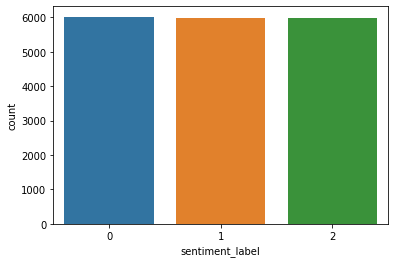

In [158]:
sns.countplot(x= y_trainMultiClassProcessed)

Como se puede comprobar, nuestro conjunto de train esta bien balanceado, por consiguiente, test también lo estará.

#### 4.2.3 TfidfVectorizer para Clasificación Multiple y Preprocesado

In [160]:
cvMultiClass = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=5000,
    ngram_range=(1, 3)
)
cvMultiClass.fit(X_trainMultiClassProcessed)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=5000,
                min_df=5, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [161]:
X_train_tfidf_MultiClassProcessed = cvMultiClass.transform(X_trainMultiClassProcessed)
X_test_tfidf_MultiClassProcessed = cvMultiClass.transform(X_testMultiClassProcessed)

#### 4.2.4 Entrenamos nuestro modelo para Clasificación Multiple y Preprocesado

#### Arbol de decisión

Optimizamos los parámetros con gridsearch

best mean cross-validation score: 0.476
best parameters: {'max_depth': 26}


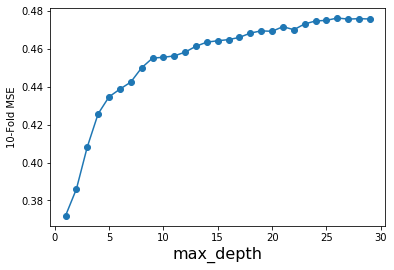

In [276]:
maxDepthDTProcessed = range(1,30)
param_gridDTProcessed = {'max_depth': maxDepthDTProcessed }
gridDTProcessed= GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_gridDTProcessed, cv = 10)
gridDTProcessed.fit(X_train_tfidf_MultiClassProcessed, y_trainMultiClassProcessed)
print("best mean cross-validation score: {:.3f}".format(gridDTProcessed.best_score_))
print("best parameters: {}".format(gridDTProcessed.best_params_))

scores = np.array(gridDTProcessed.cv_results_['mean_test_score'])
plt.plot(maxDepthDTProcessed,scores,'-o')
plt.xlabel('max_depth',fontsize=16)
plt.ylabel('10-Fold MSE')
#plt.ylim((-1, 0))
plt.show()

In [277]:
maxDepthOptimoDTProcessed = gridDTProcessed.best_params_['max_depth']
treeModelDTProcessed = DecisionTreeClassifier(max_depth=maxDepthOptimoDTProcessed).fit(X_train_tfidf_MultiClassProcessed, y_trainMultiClassProcessed)

print("Train: ",treeModelDTProcessed.score(X_train_tfidf_MultiClassProcessed, y_trainMultiClassProcessed))
print("Test: ",treeModelDTProcessed.score(X_test_tfidf_MultiClassProcessed, y_testMultiClassProcessed))



Train:  0.6715
Test:  0.4805


Predecimmos para test

In [278]:
test_predictDTProcessed = treeModelDTProcessed.predict(X_test_tfidf_MultiClassProcessed)

#### Resultado

In [279]:
print('Arbol de decisiones con preprocesado\n')
print('-' * 50)
print('Confussion matrix:\n{}'.format(confusion_matrix(yMultiClass_test, test_predictDTProcessed)))
print('\nClassification report:\n{}'.format(classification_report(yMultiClass_test, test_predictDTProcessed)))
print('Accuracy score:{}'.format(accuracy_score(yMultiClass_test, test_predictDTProcessed)))

Arbol de decisiones sin preprocesado

--------------------------------------------------
Confussion matrix:
[[ 624  314 1042]
 [ 200 1088  723]
 [ 352  486 1171]]

Classification report:
              precision    recall  f1-score   support

           0       0.53      0.32      0.40      1980
           1       0.58      0.54      0.56      2011
           2       0.40      0.58      0.47      2009

    accuracy                           0.48      6000
   macro avg       0.50      0.48      0.48      6000
weighted avg       0.50      0.48      0.48      6000

Accuracy score:0.4805


#### Baggin y Random Forest

Optimizamos los parametros con gridSearch

best mean cross-validation score: 0.594
best parameters: {'max_depth': 39}


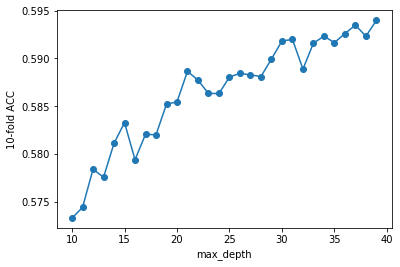

In [280]:
# grid search
maxDepthRFProcessed = range(10,40)
tuned_parametersRFProcessed = {'max_depth': maxDepthRFProcessed}

gridRFProcessed = GridSearchCV(RandomForestClassifier(random_state=0, n_estimators=200, max_features='sqrt'), param_grid=tuned_parametersRFProcessed,cv=10) 
gridRFProcessed.fit(X_train_tfidf_MultiClassProcessed, y_trainMultiClassProcessed)

print("best mean cross-validation score: {:.3f}".format(gridRFProcessed.best_score_))
print("best parameters: {}".format(gridRFProcessed.best_params_))

scores = np.array(gridRFProcessed.cv_results_['mean_test_score'])
plt.plot(maxDepthRFProcessed,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

In [283]:
maxDepthOptimoRFProcessed = gridRFProcessed.best_params_['max_depth']
bagModelRFProcessed = RandomForestClassifier(max_depth=maxDepthOptimoRFProcessed,n_estimators=200,max_features='sqrt').fit(X_train_tfidf_MultiClassProcessed, yMultiClass_train)

print("Train: ",bagModelRFProcessed.score(X_train_tfidf_MultiClassProcessed, y_trainMultiClassProcessed))
print("Test: ",bagModelRFProcessed.score(X_test_tfidf_MultiClassProcessed, y_testMultiClassProcessed))

Train:  0.9235
Test:  0.5976666666666667


In [284]:
test_predictRFProcessed = bagModelRFProcessed.predict(X_test_tfidf_MultiClassProcessed)

#### Resultado

In [285]:
print('Random Forest con preprocesado\n')
print('-' * 50)
print('Confussion matrix:\n{}'.format(confusion_matrix(yMultiClass_test, test_predictRFProcessed)))
print('\nClassification report:\n{}'.format(classification_report(yMultiClass_test, test_predictRFProcessed)))
print('Accuracy score:{}'.format(accuracy_score(yMultiClass_test, test_predictRFProcessed)))

Random Forest con preprocesado

--------------------------------------------------
Confussion matrix:
[[1163  240  577]
 [ 189 1423  399]
 [ 542  467 1000]]

Classification report:
              precision    recall  f1-score   support

           0       0.61      0.59      0.60      1980
           1       0.67      0.71      0.69      2011
           2       0.51      0.50      0.50      2009

    accuracy                           0.60      6000
   macro avg       0.60      0.60      0.60      6000
weighted avg       0.60      0.60      0.60      6000

Accuracy score:0.5976666666666667


## 5. Conclusiones

Recordemos, que en este notebook nuestro objetivo era predecir si una review era positiva, negativa o neutral.

Para poder evaluar el resultado final, vamos a ver el resultado obtenido para cada uno y así poder compararlos.

In [291]:


print('CLASIFICACIÓN BINARIA')
print('-' * 100)

print('\nTfIdfVectorizer sin preprocesado\n')
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, y_pred_tfidf_sinProcesado)))
print('\nClassification report:\n{}'.format(classification_report(y_test, y_pred_tfidf_sinProcesado)))
print('Accuracy score:{}'.format(accuracy_score(y_test, y_pred_tfidf_sinProcesado)))

print('\nTfIdfVectorizer con preprocesado\n')
print('Confussion matrix:\n{}'.format(confusion_matrix(y_testProcessed, test_predict_Processed)))
print('\nClassification report:\n{}'.format(classification_report(y_testProcessed, test_predict_Processed)))
print('Accuracy score:{}'.format(accuracy_score(y_testProcessed, test_predict_Processed)))



CLASIFICACIÓN BINARIA
----------------------------------------------------------------------------------------------------

TfIdfVectorizer sin preprocesado

Confussion matrix:
[[2617  373]
 [ 409 2601]]

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      2990
           1       0.87      0.86      0.87      3010

    accuracy                           0.87      6000
   macro avg       0.87      0.87      0.87      6000
weighted avg       0.87      0.87      0.87      6000

Accuracy score:0.8696666666666667

TfIdfVectorizer con preprocesado

Confussion matrix:
[[2510  480]
 [ 462 2548]]

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      2990
           1       0.84      0.85      0.84      3010

    accuracy                           0.84      6000
   macro avg       0.84      0.84      0.84      6000
weighted avg       0.84      0.84 

Para la clasificación binaria, es curioso que, aunque realizemos preprocesado o no, el resultado obtenido no varía demasiado, pero funciona mejor sin preprocesado.
Quizás deberíamos buscar un entremedio, es decir, procesar el texto pero no demasiado y volver a evaluarlo.

In [293]:
print('CLASIFICACIÓN MULTIPLE')
print('-' * 100)

print('\nSIN PREPROCESADO DE TEXTO\n')

print('\nÁrbol de decisiones sin preprocesado\n')
print('-' * 50)
print('Confussion matrix:\n{}'.format(confusion_matrix(yMultiClass_test, test_predictDT)))
print('\nClassification report:\n{}'.format(classification_report(yMultiClass_test, test_predictDT)))
print('Accuracy score:{}'.format(accuracy_score(yMultiClass_test, test_predictDT)))

print('\nRandom Forest sin preprocesado\n')
print('-' * 50)
print('Confussion matrix:\n{}'.format(confusion_matrix(yMultiClass_test, test_predictRF)))
print('\nClassification report:\n{}'.format(classification_report(yMultiClass_test, test_predictRF)))
print('Accuracy score:{}'.format(accuracy_score(yMultiClass_test, test_predictRF)))

print('\nCON PREPROCESADO DE TEXTO\n')

print('\nÁrbol de decisiones con preprocesado\n')
print('-' * 50)
print('Confussion matrix:\n{}'.format(confusion_matrix(yMultiClass_test, test_predictDTProcessed)))
print('\nClassification report:\n{}'.format(classification_report(yMultiClass_test, test_predictDTProcessed)))
print('Accuracy score:{}'.format(accuracy_score(yMultiClass_test, test_predictDTProcessed)))

print('\nRandom Forest con preprocesado\n')
print('-' * 50)
print('Confussion matrix:\n{}'.format(confusion_matrix(yMultiClass_test, test_predictRFProcessed)))
print('\nClassification report:\n{}'.format(classification_report(yMultiClass_test, test_predictRFProcessed)))
print('Accuracy score:{}'.format(accuracy_score(yMultiClass_test, test_predictRFProcessed)))

CLASIFICACIÓN MULTIPLE
----------------------------------------------------------------------------------------------------

SIN PREPROCESADO DE TEXTO


Árbol de decisiones sin preprocesado

--------------------------------------------------
Confussion matrix:
[[ 747  477  756]
 [ 276 1111  624]
 [ 432  497 1080]]

Classification report:
              precision    recall  f1-score   support

           0       0.51      0.38      0.43      1980
           1       0.53      0.55      0.54      2011
           2       0.44      0.54      0.48      2009

    accuracy                           0.49      6000
   macro avg       0.50      0.49      0.49      6000
weighted avg       0.50      0.49      0.49      6000

Accuracy score:0.48966666666666664

Random Forest sin preprocesado

--------------------------------------------------
Confussion matrix:
[[1226  293  461]
 [ 212 1470  329]
 [ 526  431 1052]]

Classification report:
              precision    recall  f1-score   support

       

Para clasificación múltiple, tenemos que en los dos casos, preprocesado de texto y texto en crudo, el modelo que nos ha funcionado mejor ha sido random forest. Probablemente podrímos haber subido el accuracy optimizando los parámetros, ya que si nos fijamos en las gráficas, max_deepth en la mayoría de ellas, seguía creciendo.

Aunque lo que me llama la atención aquí es que, en el modelo de random forest, la clasificación de los reviews positivos es mucho mayor a los demás. Teniendo en cuenta que nuestras muestras estaban bien balanceadas, entiendo que podría ser por que, los adjetivos para expresar disgustos o enfados, són mucho más extensos que para expresar satisfacción y alegría. 

Parece que cuando estamos contentos con poner que lo estamos, la necesidad queda satisfecha con un par de frases. Por contra, cuando se trata de expresar un sentimiento negativo, parece que necesitamos 10 líneas y aún así no queda satisfecho



Para terminar, está claro que nos ha funcionado mucho mejor la clasificación binaria sin preprocedo.

Esto se debe, a que al querer clasificar las opiniones neutrales, puede complicarlo bastante, ya que algunas pueden hacer uso de lenguajes positivos o negativos y eso puede suponer ruido para nuestro modelo.

Supongo que si hubiésemos hecho un clasificador múltiple para clasificar la intensidad, por ejemplo:

- 5 estrellas muy positivo
- 4 estrellas positivo
- 3 estrellas neutral
- 2 estrellas negativo
- 1 estrella muy negativo

Deberíamos entrenar a nuestro modelo usando bigramas o trigramas, y probablemente, clasificaría mejor entre neutrales y positivos y negativos, o eso creo